# 08_analysis_and_interpretability_svm.ipynb
##Análise de Erros e Interpretação: Modelo Robusto (TF-IDF word + char + Linear SVM)
# Objetivo:

Este notebook tem como objetivo analisar o comportamento do modelo de classificação de fake news baseado em TF-IDF de palavras e caracteres com Linear SVM, investigando não apenas seu desempenho quantitativo, mas também os padrões linguísticos que influenciam suas decisões e possíveis limitações.

# O que ele faz:

> 1. Matriz de confusão

> 2. Inspeção qualitativa dos erros:
-  Exemplos de falsos positivos mais confiantes
-  Exemplos de falsos negativos mais confiantes
-  Identificação de padrões linguísticos que induzem erro

> 3. Interpretabilidade global do modelo
> 4. Análise qualitativa do comportamento do modelo na conclusão


# Observações:

1. O modelo utilizado neste notebook corresponde ao modelo obtido no
experimento principal (TF-IDF word + char + Linear SVM), sem uso de ensemble,
por simplicidade e reprodutibilidade.

2. Neste caso, análise de erros e interpretabilidade foram realizadas conjuntamente, pois modelos lineares baseados em TF-IDF permitem relacionar diretamente os coeficientes das features com os erros observados, tornando a análise integrada mais informativa e menos redundante.

In [ ]:
# 0) Importação das bibliotecas e carregamento dos dados

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion
import re

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [ ]:
# Modelo TF-IDF word + char + Linear SVM (sem uso de ensemble)

# content = title + text (sem subject)
train["content"] = train["title"].fillna("").astype(str) + " " + train["text"].fillna("").astype(str)
test["content"]  = test["title"].fillna("").astype(str)  + " " + test["text"].fillna("").astype(str)

# Remove duplicatas completas (title+text)
train = train.drop_duplicates(subset=["title", "text"]).reset_index(drop=True)

X = train["content"].astype(str)
y = train["label"].astype(int)

# Split estratificado
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Pipeline: TF‑IDF word + TF‑IDF char + LinearSVC
# Word TF-IDF (conteúdo)
word_tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_features=200000,
    sublinear_tf=True
)

# Char TF-IDF (estilo)
char_tfidf = TfidfVectorizer(
    analyzer="char_wb",      # n-grams de caracteres dentro de limites de palavra
    ngram_range=(3, 5),
    min_df=2,
    max_features=200000,
    sublinear_tf=True
)

features = FeatureUnion([
    ("word", word_tfidf),
    ("char", char_tfidf)
])

# Linear SVM (muito forte para texto)
clf = LinearSVC(
    C=2.0,
    class_weight="balanced",   # ajuda no desbalanceamento
    random_state=42
)

pipeline = Pipeline([
    ("features", features),
    ("clf", clf)
])

# Treinar e avaliar (val)
# Para SVM,`decision_function` é usado como score e um threshold é ajustado para maximizar F1.

pipeline.fit(X_train, y_train)

# Scores contínuos (quanto maior, mais tende a classe 1)
val_scores = pipeline.decision_function(X_val)

# Busca de threshold para maximizar F1
thresholds = np.linspace(np.percentile(val_scores, 1), np.percentile(val_scores, 99), 200)
best_t = 0.0
best_f1 = -1.0

for t in thresholds:
    pred_t = (val_scores >= t).astype(int)
    f1 = f1_score(y_val, pred_t)
    if f1 > best_f1:
        best_f1 = float(f1)
        best_t = float(t)

val_pred = (val_scores >= best_t).astype(int)

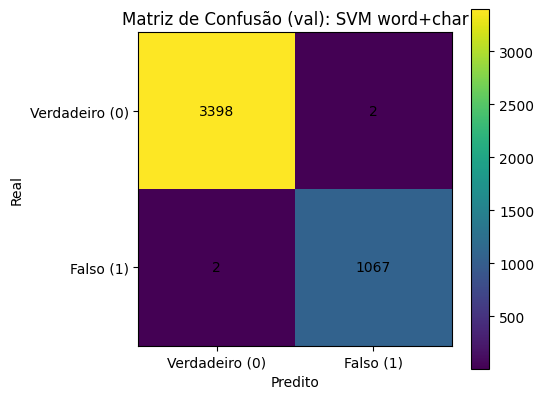

TN (0→0): 3398 | FP (0→1): 2 | FN (1→0): 2 | TP (1→1): 1067


In [ ]:
# 1) MATRIZ DE CONFUSÃO (com rótulos)
cm = confusion_matrix(y_val, val_pred, labels=[0, 1])

plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm)
plt.title("Matriz de Confusão (val): SVM word+char")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.xticks([0,1], ["Verdadeiro (0)", "Falso (1)"])
plt.yticks([0,1], ["Verdadeiro (0)", "Falso (1)"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
print(f"TN (0→0): {tn} | FP (0→1): {fp} | FN (1→0): {fn} | TP (1→1): {tp}")

In [ ]:
# 2) MOSTRAR EXEMPLOS: FP e FN mais confiantes

val_df = pd.DataFrame({
    "text": X_val.values,
    "y_true": y_val.values,
    "score_fake": val_scores,     # score contínuo pró classe 1
    "y_pred": val_pred
})

# FP: verdadeiro (0) predito como falso (1) => score_fake alto
fp_df = val_df[(val_df.y_true==0) & (val_df.y_pred==1)].sort_values("score_fake", ascending=False)

# FN: falso (1) predito como verdadeiro (0) => score_fake baixo
fn_df = val_df[(val_df.y_true==1) & (val_df.y_pred==0)].sort_values("score_fake", ascending=True)

def print_examples(df, title, k=5, snippet=420):
    print("\n" + "="*70)
    print(title)
    print("="*70)
    if len(df)==0:
        print("Nenhum exemplo encontrado.")
        return
    for i in range(min(k, len(df))):
        row = df.iloc[i]
        txt = re.sub(r"\s+", " ", str(row["text"])).strip()
        print(f"\nExemplo {i+1}")
        print(f"  y_true: {int(row['y_true'])} | y_pred: {int(row['y_pred'])} | score_fake: {float(row['score_fake']):.4f}")
        print("  Texto (trecho):", txt[:snippet], "...")

print_examples(fp_df, "FALSOS POSITIVOS (Verdadeiro->Predito como Falso) | mais confiantes", k=5)
print_examples(fn_df, "FALSOS NEGATIVOS (Falso->Predito como Verdadeiro) | mais confiantes", k=5)


FALSOS POSITIVOS (Verdadeiro->Predito como Falso) | mais confiantes

Exemplo 1
  y_true: 0 | y_pred: 1 | score_fake: 0.0542
  Texto (trecho): Trump son-in-law Kushner's congressional statement WASHINGTON (Reuters) - I am voluntarily providing this statement, submitting documents, and sitting for interviews in order to shed light on issues that have been raised about my role in the Trump for President Campaign and during the transition period. I am not a person who has sought the spotlight. First in my business and now in public service, I have worked on ac ...

Exemplo 2
  y_true: 0 | y_pred: 1 | score_fake: -0.0176
  Texto (trecho): Hackers play 30 minutes of Islamic State propaganda on Swedish radio STOCKHOLM (Reuters) - Some listeners to commercial radio station Mix Megapol in Sweden heard 30 minutes of an Islamic State propaganda song on Friday after hackers took over the station s frequency, the station s owners said. Mix Megapol is one of Sweden s biggest radio stations with aro

In [ ]:
# 3) INTERPRETABILIDADE GLOBAL: top features (word + char)

clf = pipeline.named_steps["clf"]
features_union = pipeline.named_steps["features"]

# Pega os vectorizers treinados dentro do FeatureUnion
word_vec = dict(features_union.transformer_list)["word"]
char_vec = dict(features_union.transformer_list)["char"]

word_feats = word_vec.get_feature_names_out()
char_feats = char_vec.get_feature_names_out()

all_feats = np.concatenate([word_feats, char_feats])
coef = clf.coef_.ravel()  # coef > 0 puxa para Fake (1)

topk = 20
idx_fake = np.argsort(coef)[-topk:][::-1]  # maiores coeficientes => classe 1
idx_true = np.argsort(coef)[:topk]         # menores coeficientes => classe 0

top_fake = pd.DataFrame({"feature": all_feats[idx_fake], "coef": coef[idx_fake]})
top_true = pd.DataFrame({"feature": all_feats[idx_true], "coef": coef[idx_true]})

print("\nTop features que puxam para FALSO (classe 1):")
display(top_fake)

print("\nTop features que puxam para VERDADEIRO (classe 0):")
display(top_true)


Top features que puxam para FALSO (classe 1):


,feature,coef
0,.th,2.231915
1,.the,2.098296
2,.the,2.063967
3,s,1.660746
4,read,1.321282
5,video,1.242071
6,t,1.142081
7,via:,1.137327
8,via:,1.129115
9,president trump,1.029442



Top features que puxam para VERDADEIRO (classe 0):


,feature,coef
0,reuters,-3.116445
1,-,-1.783809
2,said,-1.487522
3,reut,-1.455316
4,reu,-1.453615
5,eut,-1.452884
6,eute,-1.452027
7,reute,-1.452020
8,euter,-1.451541
9,uters,-1.446660


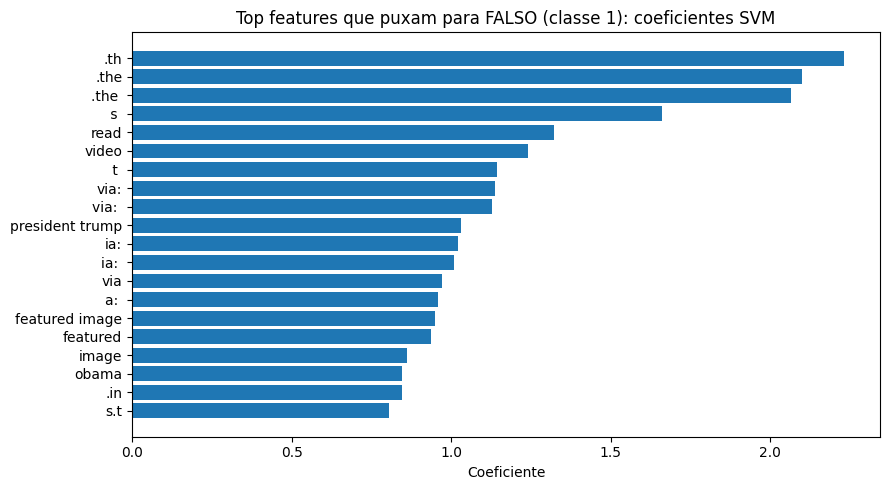

In [ ]:
# Plot classe 1 (coeficientes positivos)
# Coeficientes positivos puxam para a classe 1 (Fake).
plt.figure(figsize=(9,5))
plt.barh(top_fake["feature"][::-1], top_fake["coef"][::-1])
plt.title("Top features que puxam para FALSO (classe 1): coeficientes SVM")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()

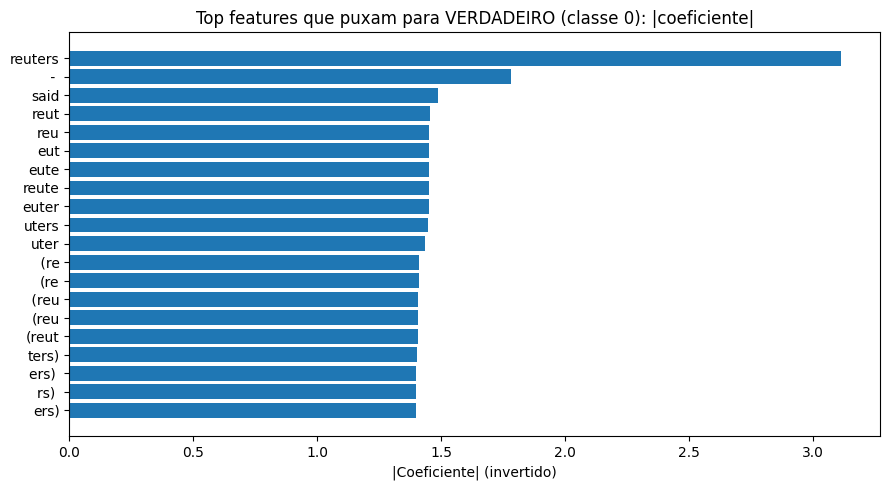

In [ ]:
# Plot classe 0 (coeficientes negativos; mostra magnitude)
# Para a classe 0 os coeficientes são negativos, então é usada a magnitude (|coef|) apenas para melhor visualização no gráfico.
plt.figure(figsize=(9,5))
plt.barh(top_true["feature"][::-1], (-top_true["coef"][::-1]))
plt.title("Top features que puxam para VERDADEIRO (classe 0): |coeficiente|")
plt.xlabel("|Coeficiente| (invertido)")
plt.tight_layout()
plt.show()

#Conclusão:
A matriz de confusão evidenciou desempenho praticamente perfeito, com número mínimo de falsos positivos e falsos negativos, confirmando a elevada capacidade discriminativa do modelo. A análise de interpretabilidade mostrou que termos associados ao estilo jornalístico profissional, especialmente marcações editoriais como “Reuters”, contribuem fortemente para a predição da classe verdadeira, enquanto padrões linguísticos típicos de conteúdos sensacionalistas ou promocionais influenciam a predição da classe falsa.

A inspeção qualitativa dos erros indicou que as principais dificuldades ocorrem quando notícias falsas imitam o formato jornalístico tradicional ou quando textos verdadeiros apresentam linguagem opinativa ou temática politicamente polarizada. Esses resultados sugerem que o modelo captura simultaneamente padrões lexicais e estilísticos, não dependendo exclusivamente de uma única palavra-chave, apesar da presença de indícios editoriais fortes no dataset.

De modo geral, a análise confirma que o modelo apresenta alta robustez e boa generalização dentro das características do conjunto de dados, ao mesmo tempo em que revela possíveis fontes de viés inerentes ao corpus utilizado.